In [2]:
import os
import numpy as np
import matplotlib
import torch
#matplotlib.use('Qt5Agg')
import matplotlib.pyplot as plt
import csv
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split,TensorDataset
from torchvision import transforms, utils
import time
import pandas as pd
import scipy.io
import sklearn.metrics
import seaborn as sns
import random

random.seed(1)
torch.manual_seed(1)
torch.cuda.manual_seed(1)
np.random.seed(1)

SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


# Writing custom dataset
class AI_Image_dataset(Dataset):
    def __init__(self, file_name):
        data = scipy.io.loadmat(file_name)
        self.X = data['data'][0, 0]['featVec']


        # Only use with object features
      
        self.Y = data['data'][0, 0]['labelVec']


    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return (self.Y[idx],self.X[idx])

#Network definition
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        n_CW = 50 # This directly affects accuracy if value is low.
        oc = 3
        self.conv1 = nn.Conv1d(4,n_CW,kernel_size=100, stride=10, padding=49)   
        self.conv2 = nn.Conv1d(n_CW,1 , kernel_size=25, stride=5, padding=31)

        self.BN1 = nn.BatchNorm1d(n_CW)
        self.BN2 = nn.BatchNorm1d(1)
        self.ln = nn.Linear(334, 200)


        self.convT1 = nn.Sequential(
            nn.ConvTranspose3d(200, 512, kernel_size=(4, 4, 4), stride=2, padding=0, bias=False),
            nn.BatchNorm3d(512),
            nn.ReLU(inplace=True)
        )
        self.convT2 = nn.Sequential(
            nn.ConvTranspose3d(512, 256, kernel_size=(4, 4, 4), stride=2, padding=1, bias=False),
            nn.BatchNorm3d(256),
            nn.ReLU(inplace=True)
        )
        self.convT3 = nn.Sequential(
            nn.ConvTranspose3d(256, 128, kernel_size=(4, 4, 4), stride=2, padding=1, bias=False),
            nn.BatchNorm3d(128),
            nn.ReLU(inplace=True)
        )
        self.convT4 = nn.Sequential(
            nn.ConvTranspose3d(128, 64, kernel_size=(4, 4, 4), stride=2, padding=1, bias=False),
            nn.BatchNorm3d(64),
            nn.ReLU(inplace=True)
        )
        self.convT5 = nn.ConvTranspose3d(64, 1, 4, 2, 1)
    def forward(self, x):
        x = (F.relu(self.conv1(x)))
        x = self.BN1(x)
        x = (F.relu(self.conv2(x)))
        x = self.BN2(x)
        x = self.ln(x)
        x = x.view(-1, 200, 1, 1, 1)
        x = self.convT1(x)
        x = self.convT2(x)
        x = self.convT3(x)
        x = self.convT4(x)
        x = self.convT5(x)
        x = F.sigmoid(x)
        # print(x.shape)
        return x

#Network definition


In [4]:
from sklearn.model_selection import train_test_split
file_name_train01=r"/content/drive/My Drive/Colab Notebooks/data_train121.mat"
file_name_test01=r"/content/drive/My Drive/Colab Notebooks/data_test25.mat"
file_name_train02=r"/content/drive/My Drive/Colab Notebooks/data_train40_xyz.mat"
file_name_test02=r"/content/drive/My Drive/Colab Notebooks/data_test25_xyz.mat"

data = scipy.io.loadmat(file_name_train01)
x_train01 = data['data'][0, 0]['featVec']
y_train01 = data['data'][0, 0]['imgVec'].reshape(-1, 1, 64, 64, 64)
data = scipy.io.loadmat(file_name_test01)
x_test01 = data['data'][0, 0]['featVec']
y_test01 = data['data'][0, 0]['imgVec'].reshape(-1, 1, 64, 64, 64)

data = scipy.io.loadmat(file_name_train02)
x_train02 = data['data'][0, 0]['featVec']
y_train02 = data['data'][0, 0]['imgVec'].reshape(-1, 1, 64, 64, 64)
data = scipy.io.loadmat(file_name_test02)
x_test02 = data['data'][0, 0]['featVec']
y_test02 = data['data'][0, 0]['imgVec'].reshape(-1, 1, 64, 64, 64)

X = np.vstack((x_train02, x_test02))
y = np.vstack((y_train02, y_test02))


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
# trainset = AI_Image_dataset(file_name_train)
# testset = AI_Image_dataset(file_name_test)
print(y_train.shape)
# print(X_val.shape)
print(X_test.shape)


(58, 1, 64, 64, 64)
(7, 4, 16320)


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


11847230.0
1548267.0
6582835.0
712373.75
4654260.0
523436.5625
3662193.0
426767.6875
3079781.0
367983.6875
2547586.5
308908.3125
2100364.0
255872.359375
1781575.0
223710.453125
1559512.0
206617.6875
1387004.25
199507.4375
1263566.0
180910.828125
1141789.5
176866.265625
1024371.0
159624.78125
943013.375
151843.953125
859088.4375
158359.71875
825975.625
167566.25
800851.75
153325.296875
734840.875
148073.671875
676033.5
153552.9375
625244.9375
154166.703125
total training time is 86.56586861610413


<Figure size 432x288 with 0 Axes>

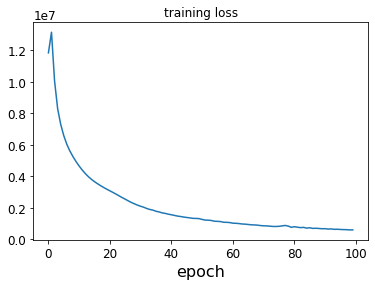

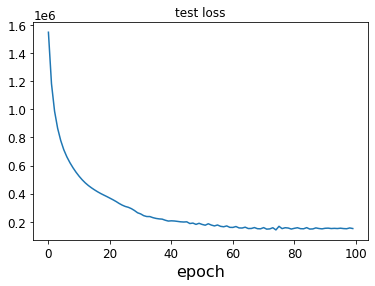

In [5]:

if __name__ == '__main__':
    
    
    #print(dataset[100])
    #print(dataset[122:124])

    #totaldata_loader = DataLoader(dataset, batch_size=len(trainset), shuffle=True)
    #print(next(iter(dataloader)))
    batchsize_train = 64

    train_loader = DataLoader(TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train)), batch_size=batchsize_train,shuffle=True)
    batchsize_test = 6
    test_loader = DataLoader(TensorDataset(torch.Tensor(X_test), torch.Tensor(y_test)), batch_size=batchsize_test, shuffle=False)
            
    
    #hyperparameter definition    
    learning_rate = 0.001    #学习的速率 越小越精细
    momentum = 0.1
    random_seed=1
    torch.backends.cudnn.enabled = False
    torch.manual_seed(random_seed)     #设定随机数种子为固定值
    
    train_loss_epoch = []
    test_acc_epoch =[]
    total_acc_epoch = []
    #epoch_range = np.arange(25,225,25)
    epoch_range = np.array([2])

    
    network = Net().cuda()
    
    #training
    optimizer = optim.Adam(network.parameters(), lr=learning_rate)
    #optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.9)
    
    plt.figure()
    
    #network.train()
    Training_Loss = []
    Test_Loss = []
    start_time = time.time()
    criterion = nn.BCELoss(reduction="sum")
    for epoch in range(100):
        train_loss = 0
        for X, Y in train_loader:
            X = X.view(-1,X.shape[1],X.shape[2]).cuda()
            X = X.float()  
            Y = Y.float().cuda() 
            current_batchsize = X.shape[0]
            optimizer.zero_grad()
            output = network(X)
            loss = criterion(output,Y)
            train_loss = train_loss + (loss.item()*current_batchsize/len(train_loader.dataset))
            loss.backward()                     #calculate the gradient decent
            optimizer.step()                    #update the weight


        with torch.no_grad():
            X = torch.Tensor(X_test).cuda()
            Y = torch.Tensor(y_test).cuda()
            X = X.view(-1,X.shape[1],X.shape[2])
            X = X.float()         
            current_batchsize = X.shape[0]
            output = network(X)
            loss = criterion(output,Y)
            test_loss = loss.item()

        Training_Loss.append(train_loss)
        Test_Loss.append(test_loss)
        if epoch%5==0:
            print(train_loss)
            print(test_loss)
        if epoch%20==0:
            torch.save(network.state_dict(), r"/content/drive/My Drive/Colab Notebooks/3D_model_{}.pt".format(epoch))
            

    
    train_loss_epoch.append(Training_Loss[-1])
    training_time=time.time()-start_time
    print('total training time is',training_time)
    
    plt.figure()
    plt.plot(Training_Loss)
    plt.title("training loss")
    plt.xlabel("epoch")
    plt.show()

    plt.figure()
    plt.plot(Test_Loss)
    plt.title("test loss")
    plt.xlabel("epoch")
    plt.show()

    



In [ ]:
import scipy.io
y_p=np.array(output.cpu())
y=np.array(Y.cpu())
y_p=y_p.reshape(-1, 64, 64, 64)
y=y.reshape(-1, 64, 64, 64)
mdic = {"y_p": y_p, "y_true": y}
scipy.io.savemat(r"/content/drive/My Drive/Colab Notebooks/test_result_all.mat", mdic)
#np.savetxt(r"/content/drive/My Drive/Colab Notebooks/test_result", y_p,y)